In [1]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# Algorithms to find the voting power of each agent in a WVG

## Lemma 1: computes the number of ways to of having an ordered partition

The following code reflects the equations seen in the proof of Lemma 1 (found in the Appendix). Instead of finding any number of  partitions of a set, this just looks at 2, 3, and 4 partitions as this is all we need for our purposes.

# Proxy voting

## Proxy Voting with no direct vote

The following code returns the voting power of each agent in a WVG when in the proxy voting with no direct vote

In [3]:
def proba_v_alpha(nv, nd, nv_p, nd_p, nd_m): # this corresponds to Equation 1 in the paper
    nv_m = nv - 1 - nv_p
    return ((nv_p)**(nd_p))*((nv_m)**(nd_m))/((2**(nv-1))*(nv**nd))

def proba_d_alpha(nv, nd, nv_p, nd_p):# this corresponds to Equation 3 in the paper
    nv_m = nv - nv_p
    nd_m = nd - 1 - nd_p
    return ((nv_p)**(nd_p))*((nv_m)**(nd_m))/((2**nv)*(nv**(nd-1)))

In [4]:
def getPowersPV_alpha(wd, wv, q):
    '''
    wd: weight vector of V_d
    wv: weight vector of V_v
    q: quota s.t. 0 < q < 1
    '''
    nd = len(wd)  #number of delegators
    nv = len(wv) #number of delegatees
    wds = int(np.sum(wd)) #total weights of the delegators
    wvs = int(np.sum(wv))#total weights of the delegatees
    ws = wds + wvs #total weights of all agents
    
    # For voting voters
    power_v = {} 
    for i in range(nv): #for a delegatee i
        w_i = wv[i] #find the voting weight of i 
        if w_i in power_v: #check that the power of the agent hasn't already been computed 
            continue
        w_not_i = np.concatenate([wv[:i],wv[i+1:]])
        mv = getAll2partitions(w_not_i)  #find all of the ways of splitting the delegatees without agent i (with respect to their weights) into those in favour and those against  
        md = getAll3partitions(wd) #find all of the ways of splitting the delegators (with respect to their weights) into 3 groups: (1) those delegating to those in favour; (2) those delegating to those against; (3) delegating to i
        
        p_tot = 0 #starting value of total prob of being critical
        for nd_p in range(nd+1): #for each of the possible number of delegators in favour
            for nd_m in range(nd+1-nd_p): # #for each of the possible number of delegators against given the number of delegators in favour
                for nv_p in range(nv): #for each of the possible number delegatees being in favour
                    p = proba_v_alpha(nv, nd, nv_p, nd_p, nd_m) #the probability of this number of agents being split in this way
                    for wd_p in range(wds+1): # the possible total weights of the delegators in favour
                        for wd_m in range(wds+1-wd_p): # the possible total weights of the delegators against, given the total weights in favour
                            for wv_p in range(wvs+1-w_i): # the possible total weights of the delegatees in favour including the weights from delegations
                                w_p = wv_p + wd_p #weight of votes in favour 
                                wd_i = (wds - wd_p - wd_m) + w_i #weight of i and those delegating to i
                                gamma_1 = mv[nv_p, wv_p]  #the number of ways to have a partition of delegatees (without i) given the number of delegatees in favour
                                gamma_2 = md[nd_p, nd_m, wd_p, wd_m] # the number of ways for the delegators to be partitioned
                                if w_p < q*ws and w_p + wd_i >= q*ws: # is i critical in this partition?
                                    if gamma_1 > 0 and gamma_2 > 0:# the partition is possible
                                        p_tot += gamma_1*gamma_2*p #adding to the total probability of being critical, the number of ways this partition could happen  (gamma1*gamma2) times by the probability of it happening
                                    
        power_v[w_i] = p_tot #returns the power of a delegatee with weight w_i 
        
    #For delegating voters
    power_d = {}
    for i in range(nd): #for a delegator i
        w_i = wd[i] #find i's weight
        if w_i in power_d: #if the power measure has already been found for this weight, then skip
            continue
        w_not_i = np.concatenate([wd[:i],wd[i+1:]]) #removing i from the from the delegators weights 
        mv = getAll2partitions(wv) #find all ways of splitting the delegatees into those in favour and those against  (with respect to their weights)
        md = getAll2partitions(w_not_i) #find all of the ways of splitting the delegators (expect the agent in question, i) into those delegating to a proxy in favour and those delegating to a proxy against
        
        p_tot = 0 #setting the total probability to 0
        for nd_p in range(nd): # for all possible numbers of delegators being in favour
            for nv_p in range(nv+1): #for all possible numbers of delegatees being in favour
                p = proba_d_alpha(nv, nd, nv_p, nd_p)  #the probability of having a partition with this number in each group
                for wd_p in range(wds+1-w_i): # for all possible total weight of the delegators in favour
                    for wv_p in range(wvs+1): # for the possible total final voting weight of the delegatees in favour given that the delegations have been taken into account
                        w_p = wv_p + wd_p #the total weight of voters in favour 
                        gamma_1 = mv[nv_p, wv_p] # the number of ways of having a partition of the delegatees given the number of those in favour and their weights
                        gamma_2 = md[nd_p, wd_p] # the number of ways of having a partition of the delegators given the number of those in favour and their weights
                        if w_p < q*ws and w_p + w_i >= q*ws: #if within this partition i is critical 
                            if gamma_1 > 0 and gamma_2 > 0: #if these partitions are possible
                                p_tot += gamma_1*gamma_2*p #adding to the total probability of being critical, the number of ways this partition could happen  (gamma1*gamma2) timesed by the probability of it happening
                                    
        power_d[w_i] = p_tot #returns the power of a delegator with weight w_i 
        
    return power_v, power_d #this returns first the power of the delegatees with respect to their weights, and then the same for the delegators

In [20]:
getPowersPV_alpha([1]*3+[2], [3,2,1], 0.5)

({3: 0.5802469135802469, 2: 0.4074074074074072, 1: 0.33333333333333315},
 {1: 0.10185185185185183, 2: 0.24074074074074073})

## Proxy voting with direct vote (complete bipartite graph)

The following code returns the voting power of each agent in a WVG when in proxy voting with direct vote, i.e. we have a complete bipartite graph

In [5]:
def proba_v_beta(nv, nd, nv_p, nd_p, nd_m, p_d): # this corresponds to Equation 2 in the paper
    nv_m = nv - 1 - nv_p
    nd_i = nd - nd_p - nd_m
    p_v = 1 - p_d
    return (1/(2**(nv-1)))*((p_v/2+p_d*(nv_p/nv))**nd_p)*((p_v/2+p_d*(nv_m/nv))**nd_m)*((p_d/nv)**nd_i)


def proba_d_beta(nv, nd, nv_p, nd_p, p_d):# this corresponds to Equation 4 in the paper
    nv_m = nv - nv_p
    nd_m = nd - 1 - nd_p
    p_v = 1 - p_d
    return (1/(2**nv))*((p_v/2+p_d*(nv_p/nv))**nd_p)*((p_v/2+p_d*(nv_m/nv))**nd_m)

In [6]:
def getPowersPV_beta(wd, wv, q, p_d):
    '''
    wd: weight vector of V_d
    wv: weight vector of V_v
    q: quota s.t. 0 < q < 1
    p_d: probability to delegates
    '''
    nd = len(wd) #number of delegators
    nv = len(wv) #number of delegatees
    wds = int(np.sum(wd)) #total sum of weights of the delegators
    wvs = int(np.sum(wv)) #total sum of weights of the delegatees
    ws = wds + wvs #total sum of the agents' weights 
    
    power_v = {}
    #for the delegatees (voting agents)
    for i in range(nv): # for delegatee i
        w_i = wv[i] #find i's weight
        if w_i in power_v: #if the power measure has already been found for a delegatee then we don't compute it again
            continue
        w_not_i = np.concatenate([wv[:i],wv[i+1:]]) #remove i from the weight vector of delegatees
        mv = getAll2partitions(w_not_i) #find all 2 partitions of the delegatees not involving i: (1) those in favour; (2) those against
        md = getAll3partitions(wd)  #find all 3 partitions of the delegators: (1) those delegating to a proxy in favour; (2) those delegating to a proxy against; (3) those delegating to i

        p_tot = 0 #starting value of total prob of being critical
        for nd_p in range(nd+1): #for each of the possible number of delegators in favour
            for nd_m in range(nd+1-nd_p): # for each of the possible number of delegators against given the number of delegators in favour
                for nv_p in range(nv): #for each of the possible number delegatees being in favour
                    p = proba_v_beta(nv, nd, nv_p, nd_p, nd_m, p_d) #the probability of this partition happening without i (given that i is a delegatee)
                    for wd_p in range(wds+1): # the possible total weights of the delegators in favour
                        for wd_m in range(wds+1-wd_p):# the possible total weights of the delegators against, given the total weights in favour
                            for wv_p in range(wvs+1-w_i):# the possible total weights of the delegatees in favour including the weights from delegations
                                w_p = wv_p + wd_p #the total voting weight in favour (from both the delegators and the delegatees)
                                wd_i = (wds - wd_p - wd_m) + w_i #the total voting weight of i and those delegating to i
                                gamma_1 = mv[nv_p, wv_p]  #the number of ways to have a partition of delegatees (without i) given the number of delegatees in favour
                                gamma_2 = md[nd_p, nd_m, wd_p, wd_m] # the number of ways for the delegators to be partitioned
                                if w_p < q*ws and w_p + wd_i >= q*ws: #if within this partition i is critical
                                    if gamma_1 > 0 and gamma_2 > 0: #if these partitions are possible
                                        p_tot += gamma_1*gamma_2*p #adding to the total probability of being critical, the number of ways this partition could happen  (gamma1*gamma2) times by the probability of it happening
                                        
        power_v[w_i] = p_tot #returns the power of a delegatee with weight w_i
        
        
    #for the delegators 
    power_d = {}
    for i in range(nd): #for each delegator i
        w_i = wd[i] #fing i's weight 
        if w_i in power_d: #if the power measure has already been found for this weight, then skip
            continue
        w_not_i = np.concatenate([wd[:i],wd[i+1:]]) #removing i from the from the delegators weights 
        mv = getAll2partitions(wv)#find all ways of splitting the delegatees into those in favour and those against  (with respect to their weights)
        md = getAll2partitions(w_not_i) #find all of the ways of splitting the delegators (expect the agent in question, i) into those delegating to a proxy in favour and those delegating to a proxy against
        
        p_tot = 0 #starting value of total prob of being critical
        for nd_p in range(nd): #for every possible number of delegators in favour
            for nv_p in range(nv+1): # for every possible number of delegatees in favour
                p = proba_d_beta(nv, nd, nv_p, nd_p, p_d) #the probability of this partition happening without i (given that i is a delegator)
                for wd_p in range(wds+1-w_i):# #for every possible weight out of the total weights of the delegators without i
                    for wv_p in range(wvs+1):# for every possible sum of the weight of the delegatees who are in favour
                        w_p = wv_p + wd_p #the total weight of voters in favour 
                        gamma_1 = mv[nv_p, wv_p]  # the number of ways of having a partition of the delegatees given the number of those in favour and their weights
                        gamma_2 = md[nd_p, wd_p] # the number of ways of having a partition of the delegators given the number of those in favour and their weights
                        if w_p < q*ws and w_p + w_i >= q*ws:#if within this partition i is critical
                            if gamma_1 > 0 and gamma_2 > 0: #if these partitions are possible
                                p_tot += gamma_1*gamma_2*p #adding to the total probability of being critical, the number of ways this partition could happen  (gamma1*gamma2) times by the probability of it happening
                       
        power_d[w_i] = p_tot #returns the power of a delegator with weight w_i
        
        
    return power_v, power_d  #this returns the first the power of the delegatees with respect to their weights, and then the same for the delegators

Obtaining the voting power $\mathcal{M}^\beta$ of the agents in Example 2 when the probability of delegating is $p_d=0$ (as seen in Table 1)

In [7]:
getPowersPV_beta([1]*3+[2], [3,2,1], 0.5, 0)

({3: 0.59375, 2: 0.34375, 1: 0.15625}, {1: 0.15625, 2: 0.34375})

Obtaining the voting power $\mathcal{M}^\beta$ of the agents in Example 2 when the probability of delegating is $p_d=0.5$ (as seen in Table 1)

In [8]:
getPowersPV_beta([1]*3+[2], [3,2,1], 0.5, 0.5)

({3: 0.5946421682098763, 2: 0.3752170138888889, 1: 0.24862557870370364},
 {1: 0.12948495370370366, 2: 0.2944155092592591})

# Liquid Democracy: LD

The following code returns the voting power of each agent in a WVG when in LD.

In [9]:

def binom(n, k):
    return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

def proba_ld_0(n0, n, p_d):  #the equation can be found on page 6 of the paper, just above Definition 7
    return (p_d*(n0-1)/(n-1))**(n0)

def proba_ld(n, p, p_d):  # this corresponds to Equation 5 in the paper
    tab_p_d = np.ones(n)*-1
    tab_p = np.ones(n)*-1
    tab_p[0] = 1
    tab_p_d[0] = 1
    tab_p[1] = p
    tab_p_d[1] = p_d/(n-1)
    
    def fillCell(m, pi):
        if pi == p and tab_p[m] >= 0:
            return tab_p[m]
        if pi == p_d/(n-1) and tab_p_d[m] >= 0:
            return tab_p_d[m]
        c = 0
#         print(m, pi)
        for m1 in range(m): #the summation in Eq 5
            s = binom(m-1, m1)
            s *= fillCell(m1, p_d/(n-1))
            s *= fillCell(m - 1 - m1, pi)
            s *= (pi + p_d*(m - 1 - m1)/(n-1))
            c += s
        if pi == p:
            tab_p[m] = c
        else:
            tab_p_d[m] = c
        return c
    
    for i in range(2, n):
        tab_p[i] = fillCell(i, p)
    
    return tab_p

In [10]:
def getPowersLD(w, q, p_d):
    '''
    w: weight vector of V
    q: quota s.t. 0 < q < 1
    p_d: probability to delegates
    '''
    n = len(w)  #number of voters
    ws = np.sum(w) #total weights
    p_v = 1 - p_d #probability of voting is 1- probability of delegating
    
    power_v = {}
    
    pl_pv = proba_ld(n, p_v/2, p_d)  
    pl_pd = proba_ld(n, p_d/(n-1), p_d)
    
    
    for i in range(n): # for each agent
        w_i = w[i] #find their weight
        if w_i in power_v: #if the power measure for this weight has already been found, then skip
            continue
        w_not_i = np.concatenate([w[:i],w[i+1:]])
        mv = getAll4partitions(w_not_i) #find all 4-partitions of the agents without agent i: (1) agents voting in favour; (2) agents voting against; (3) agents caught in a cycle V^0; (4) agents delegating to i 
        
        p_tot = 0 
        for n_p in range(n): #for the number of possible agents in favour
            for n_m in range(n-n_p): #for the number of possible agents against given the number of those in favour
                for n_0 in range(n-n_p-n_m): #for the number of possible agents in a cycle given the number of those in favour and those against
                    n_i = n-1-n_p-n_m-n_0 #number of agents delegating to i is n  minus 1 (for i), the number of agents in favour n_p (directly or indirectly), the number of agents against n_m  (directly or indirectly), and the number of agents caught in a cycle 
                    p = proba_ld_0(n_0, n, p_d)  #probability of those in V^0 being in a cycle
                    p *= pl_pv[n_p] #probability of the n_p agents in V^+ voting for the issue (either directly or indirectly) 
                    p *= pl_pv[n_m] #probability of the n_m agents in V^- voting against the issue (either directly or indirectly) 
                    p *= pl_pd[n_i] #probability of the n_i agents in V^i delegating to i (directly or indirectly)
                    for w_p in range(ws+1-w_i):  #for the possible total weight of the agents in favour
                        for w_m in range(ws+1-w_i-w_p): #for the possible total weight of the agents against 
                            for w_0 in range(ws+1-w_i-w_p-w_m): #for the possible total weight of the agents in a cycle
                                wd_i = ws - w_p - w_m - w_0 - w_i #given the values of w_p, w_m, and w_0
                                w_i_tot = wd_i + w_i # agent i's voting weight is their own weight and that of those delegating to them
                                gamma = mv[n_p, n_m, n_0, w_p, w_m, w_0] #get the number of 4-partitions of these weights and sizes of V^+, V^- and V^0
                                if w_p < q*(ws-w_0) and w_p + w_i_tot >= q*(ws-w_0): #are they critical
                                    if gamma > 0: #does such a partition exist
                                        p_tot += gamma*p #add the number of times this partition happens times by the probability of it happening and add it to the total
                                    
        power_v[w_i] = p_tot # add the power measure for agents with this weight
        
    return power_v   #this returns the power of the agents with respect to their weights

Obtaining the voting power $\mathcal{M}^{ld}$ of the agents in Example 3 when the probability of delegating is $p_d=0$ (as seen in Table 2)

In [11]:
getPowersLD([1]*4+[2,2,3], 0.5, 0)

{1: 0.15625, 2: 0.34375, 3: 0.59375}

Obtaining the voting power $\mathcal{M}^{ld}$ of the agents in Example 3 when the probability of delegating is $p_d=0.5$ (as seen in Table 2)

In [12]:
getPowersLD([1]*4+[2,2,3], 0.5, 0.5)

{1: 0.28573294431584356, 2: 0.4022834683641976, 3: 0.5521576806841566}

Obtaining the voting power $\mathcal{M}^{ld}$ of the agents in Example 3 when the probability of delegating is $p_d=0.9$ (as seen in Table 2)

In [13]:
getPowersLD([1]*4+[2,2,3], 0.5, 0.9)

{1: 0.721672656250001, 2: 0.7738309375000005, 3: 0.82531971875}

# Experiments

## PV-$\alpha$

In [43]:
n_voters = 20
tab_n = range(1, n_voters+1)
len_tab = len(tab_n)
tab_res = np.zeros((2, len_tab))

for i, n in tqdm(enumerate(tab_n)):
    p_v, p_d = getPowersPV_alpha([1]*(n_voters-n), [1]*(n), 0.5)
    tab_res[0, i] = p_v[1]
    if 1 in p_d:
        tab_res[1, i] = p_d[1]

20it [00:22,  1.11s/it]


In [41]:
tab_res
plt.plot([n for n in tab_n], tab_res[0],'o', linestyle='solid' , label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_res[1][:-1], 'v',linestyle='dotted', label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.xlim(1,n_voters)
#plt.title(r'$%i$ voters'%n_voters)
plt.xlabel(r'$|V_v|$')
plt.ylim(0,1)
plt.ylabel(r'Probability of being critical')

Text(0, 0.5, 'Probability of being critical')

## PV-$\beta$

In [44]:
n_voters = 20
tab_n = range(1, n_voters+1)
len_tab = len(tab_n)
tab_resb = np.zeros((2, len_tab))

for i, n in tqdm(enumerate(tab_n)):
    p_v, p_d = getPowersPV_beta([1]*(n_voters-n), [1]*(n), 0.5, 0.5)
    tab_resb[0, i] = p_v[1]
    if 1 in p_d:
        tab_resb[1, i] = p_d[1]

20it [00:23,  1.18s/it]


In [46]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

tab_res
plt.plot([n for n in tab_n], tab_res[0],'o', linestyle='solid' , label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_res[1][:-1], 'v',linestyle='dotted', label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.xlim(1,n_voters)
#plt.title(r'$%i$ voters'%n_voters)
plt.xlabel(r'$|V_v|$')
plt.ylim(0,1)
plt.ylabel('Probability of being critical')
tab_resb
plt.plot([n for n in tab_n], tab_resb[0], 's', linestyle = 'dashed', label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_resb[1][:-1], '*', linestyle = '-.' ,label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
#plt.xlim(1,n_voters)
#plt.title("%i voters"%n_voters)
#plt.xlabel("Number of voting voters")
#plt.ylim(0,1)
#plt.ylabel("Power")
plt.show()

In [47]:
n_voters = 20
tab_n = np.linspace(0,1,11)
len_tab = len(tab_n)
tab_res = np.zeros((2, len_tab))

for i, p_d in tqdm(enumerate(tab_n)):
    p_v, p_d = getPowersPV_beta([1]*15, [1]*5, 0.5, p_d)
    tab_res[0, i] = p_v[1]
    if 1 in p_d:
        tab_res[1, i] = p_d[1]

11it [00:24,  2.19s/it]


In [49]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

tab_res
plt.plot([n for n in tab_n], tab_res[0], 'o', ls = '-',label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n], tab_res[1], 's', ls = '--',label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.xlim(0,1)
#plt.title("20 voters (5 representants)")
plt.xlabel(r'$p_d$')
plt.ylabel('Probability of being critical')
plt.show()

## LD

In [ ]:
n_voters = 20
tab_n = np.linspace(0,1,11)
len_tab = len(tab_n)
tab_res = np.zeros((3,len_tab))

for i, p_d in tqdm(enumerate(tab_n)):
    p_v = getPowersLD([1]*10+[2]*5+[5]*5, 0.5, p_d)
    tab_res[0][i] = p_v[1]
    tab_res[1][i] = p_v[2]
    tab_res[2][i] = p_v[5]


0it [00:00, ?it/s]

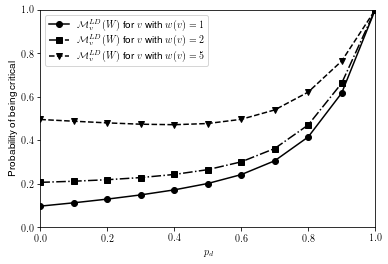

In [8]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

tab_res
plt.plot([n for n in tab_n], tab_res[0], '-o', label = r'$\mathcal{M}^{LD}_v(W)$ for $v$ with $w(v)=1$', color="black")
plt.plot([n for n in tab_n], tab_res[1], '-.s', label = r'$\mathcal{M}^{LD}_v(W)$ for $v$ with $w(v)=2$', color="black")
plt.plot([n for n in tab_n], tab_res[2], '--v', label = r'$\mathcal{M}^{LD}_v(W)$ for $v$ with $w(v)=5$', color="black")

plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
#plt.title("10 voters")
plt.xlabel(r'$p_d$')
plt.ylabel('Probability of being critical')
plt.show()

In [94]:
n_voters = 10
tab_n = np.linspace(0,1,11)
len_tab = len(tab_n)
tab_res = np.zeros((2,len_tab))

for i, p_d in tqdm(enumerate(tab_n)):
    p_v = getPowersLD([1]*6+[2]*4, 0.5, p_d)
    tab_res[0,i] = p_v[1]
    tab_res[1,i] = p_v[2]

11it [05:38, 30.78s/it]


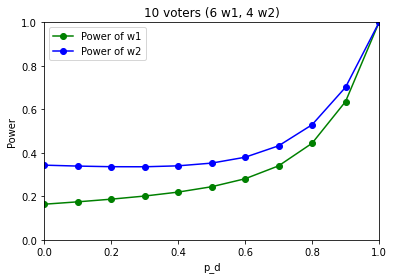

In [96]:
tab_res
plt.plot([n for n in tab_n], tab_res[0], '-o', label = "Power of w1", color="g")
plt.plot([n for n in tab_n], tab_res[1], '-o', label = "Power of w2", color="b")
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("10 voters (6 w1, 4 w2)")
plt.xlabel("p_d")
plt.ylabel("Power")
plt.show()